pvfactors: Jupyter notebook guide
============================

Updated on 11/13/2018 by Marc Anoma

This Jupyter notebook demonstrates how to use the package for irradiance calculations.

<h3>Imports and settings</h3>

In [1]:
# Import external libraries
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

# Settings
% matplotlib inline
np.set_printoptions(precision=3, linewidth=300)

## TL;DR

Given some timeseries inputs:

In [2]:
timestamps = np.array([datetime(2017, 8, 31, 11), datetime(2017, 8, 31, 12)])
solar_zenith = np.array([20., 10.])
solar_azimuth = np.array([110., 140.])
tracker_theta = np.array([10., 0.])
surface_azimuth = np.array([90., 90.])
dni = np.array([1000., 300.])
dhi = np.array([50., 500.])

And some PV array parameters:

In [3]:
pvarray_parameters = {
    'n_pvrows': 3,  # number of pv rows
    'pvrow_height': 1.75,  # height of pvrows (measured at center / torque tube)
    'pvrow_width': 2.44,  # width of pvrows
    'gcr': 0.4,  # ground coverage ratio
    'rho_ground': 0.2,  # albedo
}

The user can quickly run a timeseries simulation using ``pvfactors`` as shown below:

In [4]:
from pvfactors.timeseries import calculate_radiosities_serially_perez

df_registries, _ = calculate_radiosities_serially_perez((
    pvarray_parameters, timestamps, 
    solar_zenith, solar_azimuth, 
    tracker_theta, surface_azimuth, dni, dhi))

Progress: |██████████████████████████████████████████████████| 100.0% Complete


If the raw outputs are too detailed for the user, they can be formatted quickly thanks to helper functions:

In [5]:
from pvfactors.timeseries import get_average_pvrow_outputs

In [6]:
df_avg_outputs = get_average_pvrow_outputs(df_registries)
df_avg_outputs

pvrow_index                        0                                       \
surface_side                    back                                        
term                circumsolar_term direct_term horizon_band_shading_pct   
timestamps                                                                  
2017-08-31 11:00:00              0.0         0.0                25.568631   
2017-08-31 12:00:00              0.0         0.0                 0.000000   

pvrow_index                                                                \
surface_side                                                                
term                horizon_term irradiance_term isotropic_term        q0   
timestamps                                                                  
2017-08-31 11:00:00     1.221181        1.221181       0.117972  4.666979   
2017-08-31 12:00:00     0.000000        0.000000       0.863797  4.159874   

pvrow_index                                            ...                  2  \
surface_side                                           ...              front   
term                      qinc reflection_term shaded  ...   circumsolar_term   
timestamps                                             ...                      
2017-08-31 11:00:00  93.339589       92.000435  False  ...          30.164599   
2017-08-31 12:00:00  83.197488       82.333691  False  ...         293.667599   

pvrow_index                                                            \
surface_side                                                            
term                direct_term horizon_band_shading_pct horizon_term   
timestamps                                                              
2017-08-31 11:00:00  981.226027                      0.0     1.640681   
2017-08-31 12:00:00  295.442326                      0.0     0.000000   

pvrow_index                                                                 \
surface_side                                                                 
term                irradiance_term isotropic_term         q0         qinc   
timestamps                                                                   
2017-08-31 11:00:00     1013.031306      20.849825  31.046683  1034.889434   
2017-08-31 12:00:00      589.109925     206.332401  23.863270   795.442326   

pvrow_index                                 
surface_side                                
term                reflection_term shaded  
timestamps                                  
2017-08-31 11:00:00    1.008302e+00  False  
2017-08-31 12:00:00   -5.684342e-14  False  

[2 rows x 60 columns]

The user can also plot the pv array at a given time of the simulation:

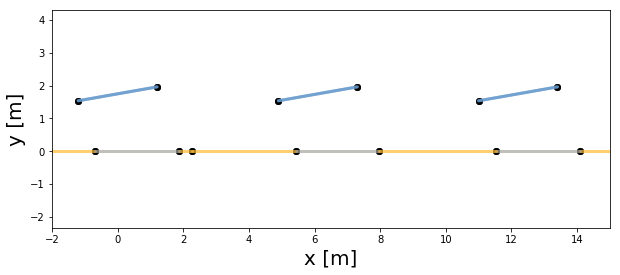

In [7]:
from pvfactors.plot import plot_array_from_registry

f, ax = plt.subplots(figsize=(10, 4))
plot_array_from_registry(ax, df_registries.set_index('timestamps').loc["2017-8-31 11:00:00", :])
ax.set_xlim(-2, 15)
plt.show()

Notes:

* In the dataframe shown above, the user can quickly access the values of not only the total irradiance incident of the PV row front and back surfaces with 'qinc', but also all the irradiance components that sum up to this like 'circumsolar_term', 'direct_term', 'horizon_term', 'isotropic_term', or 'reflected_term'.  

* ``pvfactors`` builds on top of the ``pvlib`` implementation of the Perez diffuse light transposition model to get all the light components it needs. But if the user wants to provide the components directly, this can be bypassed by using ``pvfactors.timeseries.array_timeseries_calculate()`` directly.

* The above calculation can also be run using multiprocessing by using ``pvfactors.timeseries.calculate_radiosities_parallel_perez()``.

## Create PV Array of 3 rows

We provide 2 examples for creating PV arrays.

* one where the PV array is created with continuous array surfaces
* and one where we discretize the front surface of the middle PV row

In [8]:
# Arguments
arguments = {
    'n_pvrows': 3,
    'pvrow_height': 1.75,
    'pvrow_width': 2.44,
    'axis_azimuth': 90.,  # south-north oriented torque-tubes
    'tracker_theta': 20.,  # positive rotation angles in the east
    'gcr': 0.4,
    'solar_zenith': 20.,
    'solar_azimuth': 90.,  # sun located in the east
    'rho_ground': 0.2,
    'rho_front_pvrow': 0.01,
    'rho_back_pvrow': 0.03
}

In [9]:
from pvfactors.pvarray import Array
# Create array object
array_simple = Array(**arguments)

A PV array can be visualized thanks to the ``shapely`` geometries contained in the ``surface_registry``, attribute of the ``Array`` object.

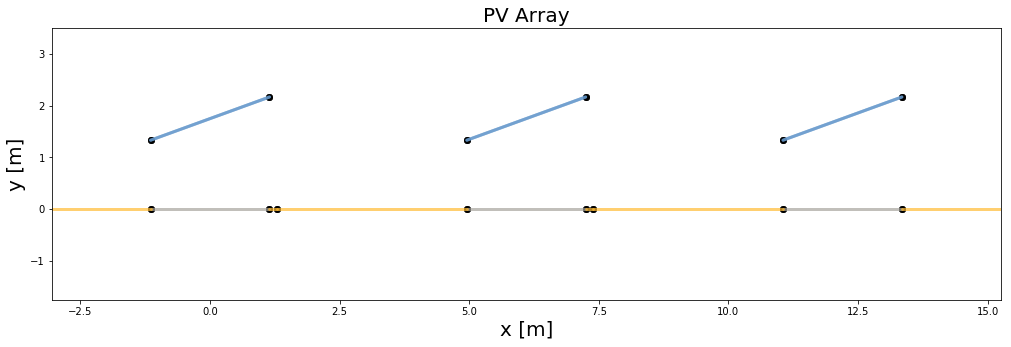

In [10]:
# Plot the PV array geometry
from pvfactors.plot import plot_pvarray
f, ax = plt.subplots(figsize=(17, 5))
plot_pvarray(ax, array_simple)
plt.show()

The user can discretize the front surface of middle tracker into 5 segments

In [11]:
# Add discretization option into arguments
arguments_discretize = arguments.copy()
arguments_discretize['cut'] = [(1, 5, 'front')]

In [12]:
# Create array object
array_discretized = Array(**arguments_discretize)

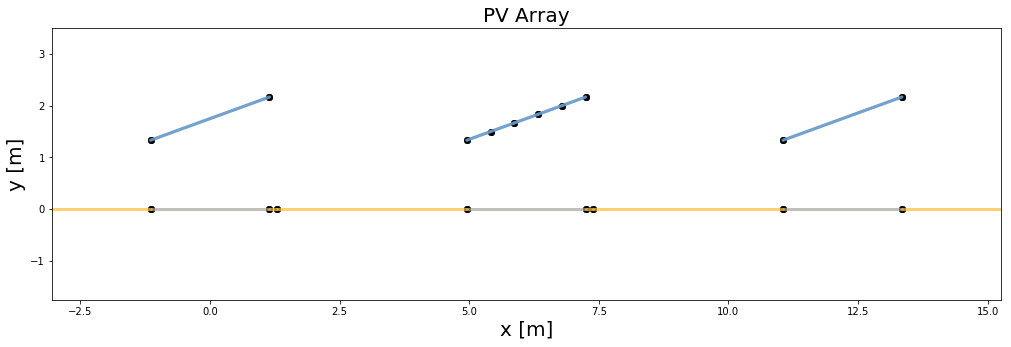

In [13]:
# Plot the PV array geometry
f, ax = plt.subplots(figsize=(17, 5))
plot_pvarray(ax, array_discretized)
plt.show()

The PV array and solar angles can be updated as follows:<br>
For example, we can rotate the array to -20 degrees

In [14]:
solar_zenith = 20.
solar_azimuth = 90.
tracker_theta = -20.
surface_azimuth = 270.
array_discretized.update_view_factors(solar_zenith, solar_azimuth, 
                                      tracker_theta, surface_azimuth)

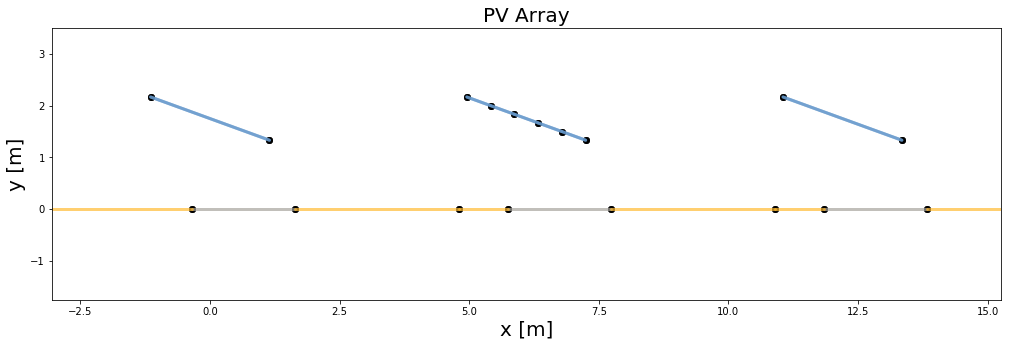

In [15]:
# Plot the PV array geometry
f, ax = plt.subplots(figsize=(17,5))
plot_pvarray(ax, array_discretized)
plt.show()

## Direct shading (still in development)

We can also look at cases of direct shading.

In [16]:
solar_zenith = 80.
solar_azimuth = 90.
tracker_theta = 70.
surface_azimuth = 90.
array_simple.update_view_factors(solar_zenith, solar_azimuth, 
                                 tracker_theta, surface_azimuth)

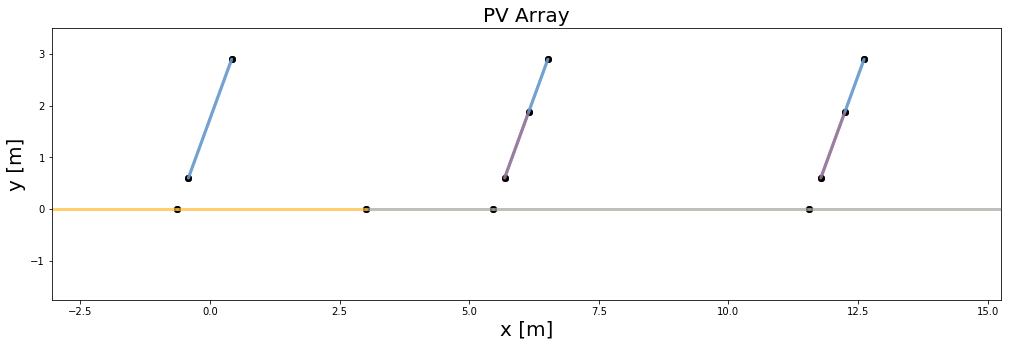

In [17]:
# Plot the PV array geometry
f, ax = plt.subplots(figsize=(17,5))
plot_pvarray(ax, array_simple)
plt.show()

We can see in the figure above that the middle and the right trackers are undergoing some row-to-row shading

## Surface Registry

The ``surface_registry`` of the array contains all the info necessary for the calculations, including the ``shapely`` geometries.<br>
The user can for instance select elements of the PV array by filtering on "line_type" (PV row or ground surface), "shaded" (is the surface shaded?), "surface_side" (which side of the surface), etc.

In [18]:
array_simple.surface_registry.head()

,geometry,style,line_type,shaded,pvrow_index,pvrow_segment_index,index_pvrow_neighbor,edge_point,surface_side,surface_centroid,...,reflectivity,irradiance_term,direct_term,isotropic_term,circumsolar_term,horizon_term,circumsolar_shading_pct,horizon_band_shading_pct,q0,qinc
0,LINESTRING (-0.4172645748573156 0.603575002641...,-,pvrow,False,0.0,NaN,NaN,POINT (-0.6369479099658538 0),front,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LINESTRING (5.682735425142684 0.60357500264119...,-,pvrow,True,1.0,NaN,0.0,POINT (5.463052090034146 0),front,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LINESTRING (11.78273542514268 0.60357500264119...,-,pvrow,True,2.0,NaN,1.0,POINT (11.56305209003415 0),front,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"LINESTRING (3.005779364397384 0, 5.46305209003...",-,ground,True,NaN,NaN,NaN,NaN,front,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"LINESTRING (-100 0, -0.6369479099658548 0)",-,ground,False,NaN,NaN,NaN,NaN,front,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## View factor matrix

The view factor matrix of the array is automatically calculated when the array is created or updated.

In [19]:
# Calculate matrix
print(array_simple.vf_matrix)

[[ 0.     0.     0.     0.     0.321  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.679]
 [ 0.     0.     0.     0.162  0.038  0.     0.083  0.     0.     0.188  0.     0.     0.     0.     0.528]
 [ 0.     0.     0.     0.022  0.005  0.     0.012  0.245  0.     0.     0.188  0.     0.     0.     0.528]
 [ 0.     0.09   0.012  0.     0.     0.     0.     0.     0.     0.102  0.     0.     0.039  0.012  0.745]
 [ 0.008  0.001  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.991]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.001  0.     0.     0.999]
 [ 0.     0.031  0.004  0.     0.     0.     0.     0.     0.     0.279  0.     0.     0.029  0.     0.657]
 [ 0.     0.     0.055  0.     0.     0.     0.     0.     0.     0.02   0.208  0.     0.     0.033  0.684]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.007  0.087  0.     0.     0.905]
 [ 0.     0.105  0.     0.10

The view matrix lines and columns can be labeled using the surface registry

In [20]:
# Create labels for the matrix
registry = array_simple.surface_registry
registry.loc[registry.line_type == 'ground', 'pvrow_index'] = range(
    registry.loc[registry.line_type == 'ground', :].shape[0])
labels = (registry.line_type.values + "_" + 
          registry.pvrow_index.values.astype(str) + "_" + 
          registry.surface_side.values)

# Show the matrix with labels
labeled_vf_matrix = pd.DataFrame(array_simple.vf_matrix[:-1, :-1], 
                                 index=labels, columns=labels)
labeled_vf_matrix

,pvrow_0.0_front,pvrow_1.0_front,pvrow_2.0_front,ground_0.0_front,ground_1.0_front,ground_2.0_front,ground_3.0_front,ground_4.0_front,ground_5.0_front,pvrow_0.0_back,pvrow_1.0_back,pvrow_2.0_back,pvrow_1.0_front,pvrow_2.0_front
pvrow_0.0_front,0.000000,0.000000,0.000000,0.000000,0.320807,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
pvrow_1.0_front,0.000000,0.000000,0.000000,0.162252,0.038206,0.000000,0.083054,0.000000,0.000000,0.188039,0.000000,0.000000,0.000000,0.000000
pvrow_2.0_front,0.000000,0.000000,0.000000,0.021514,0.005133,0.000000,0.011564,0.245306,0.000000,0.000000,0.188039,0.000000,0.000000,0.000000
ground_0.0_front,0.000000,0.090091,0.011945,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.102125,0.000000,0.000000,0.038559,0.012395
ground_1.0_front,0.007878,0.000525,0.000070,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000311,0.000000
ground_2.0_front,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000011,0.000018,0.001388,0.000000,0.000000
ground_3.0_front,0.000000,0.031108,0.004332,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.278817,0.000000,0.000000,0.028997,0.000112
ground_4.0_front,0.000000,0.000000,0.054868,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020334,0.207639,0.000000,0.000000,0.032849
ground_5.0_front,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000403,0.007466,0.086715,0.000000,0.000000
pvrow_0.0_back,0.000000,0.105148,0.000000,0.102848,0.000000,0.000307,0.416251,0.050835,0.002887,0.000000,0.000000,0.000000,0.068373,0.000000


## Calculate radiosities for single time point and using isotropic diffuse sky dome approach

In [21]:
# Define input values for radiosity calculation
DNI = 1000.
DHI = 50.
solar_zenith = 20.
solar_azimuth = 90.
tracker_theta = -20.
surface_azimuth = 270.

# Back fill other inputs
luminance_isotropic = DHI
luminance_circumsolar = 0.
poa_horizon = 0.
poa_circumsolar = 0.

In [22]:
array_simple.calculate_radiosities_perez(solar_zenith, solar_azimuth, 
                                         tracker_theta, surface_azimuth,
                                         DNI, luminance_isotropic,
                                         luminance_circumsolar, poa_horizon,
                                         poa_circumsolar)

In [23]:
array_simple.surface_registry[['pvrow_index', 'shaded', 'line_type', 
                               'surface_side', 'irradiance_term', 'q0', 
                               'qinc', 'isotropic_term', 'reflection_term']]

,pvrow_index,shaded,line_type,surface_side,irradiance_term,q0,qinc,isotropic_term,reflection_term
0,0.0,False,pvrow,front,766.044443,8.168828,816.882800,47.572225,3.266131
1,1.0,False,pvrow,front,766.044443,8.173178,817.317825,47.573077,3.700304
2,2.0,False,pvrow,front,766.044443,8.200154,820.015392,48.657804,5.313145
3,NaN,True,ground,front,0.000000,5.297125,26.485623,24.658496,1.827127
4,NaN,True,ground,front,0.000000,5.297799,26.488993,24.815420,1.673573
5,NaN,True,ground,front,0.000000,5.693934,28.469672,26.933075,1.536597
6,NaN,False,ground,front,939.692621,195.553701,977.768507,37.217601,0.858285
7,NaN,False,ground,front,939.692621,195.651303,978.256514,37.744932,0.818961
8,NaN,False,ground,front,939.692621,197.806118,989.030592,49.286484,0.051487
9,NaN,False,ground,front,939.692621,197.396142,986.980708,47.067908,0.220179


Functions like ``pvfactors.timeseries.calculate_custom_perez_transposition()`` can help the user get the needed outputs from Perez model.

## Timeseries calculation of radiosity terms

### For simple continuous surfaces

The user can use the function from the ``pvfactors.timeseries`` module named ``calculate_radiosities_serially_perez()``, which will pre-calculate the necessary inputs from the Perez model using the ``pvlib`` library.<br>
The user can also use ``calculate_radiosities_parallel_perez()``, which will run the same calculations but in parallel processes.

Let's create some inputs for the function:

In [24]:
timestamps = np.array([datetime(2017, 8, 31, 11), datetime(2017, 8, 31, 12)])
solar_zenith = np.array([20., 10.])
solar_azimuth = np.array([110., 140.])
tracker_theta = np.array([10., 0.])
surface_azimuth = np.array([90., 90.])
dni = np.array([1000., 300.])
dhi = np.array([50., 500.])

That's all we need to run a calculation

In [25]:
df_registries, _ = calculate_radiosities_serially_perez((
    pvarray_parameters, timestamps, 
    solar_zenith, solar_azimuth, 
    tracker_theta, surface_azimuth, dni, dhi))

Progress: |██████████████████████████████████████████████████| 100.0% Complete


The output of the calculation is a timestamped concatenation of all the ``surface_registries`` calculated for each simulation timestamp.

In [26]:
# Show the surface averaged outputs for the PV rows
df_registries.set_index('timestamps').head(3)

,geometry,style,line_type,shaded,pvrow_index,pvrow_segment_index,index_pvrow_neighbor,edge_point,surface_side,surface_centroid,...,irradiance_term,direct_term,isotropic_term,circumsolar_term,horizon_term,circumsolar_shading_pct,horizon_band_shading_pct,q0,qinc,reflection_term
timestamps,,,,,,,,,,,,,,,,,,,,,
2017-08-31 11:00:00,LINESTRING (-1.201465458674894 1.5381492232463...,-,pvrow,False,0.0,NaN,NaN,POINT (-9.924743184331003 0),front,POINT (0 1.75),...,1013.031306,981.226027,20.982303,30.164599,1.640681,0.0,0.000000,31.056947,1035.231572,1.217963
2017-08-31 11:00:00,LINESTRING (4.898534541325105 1.53814922324634...,-,pvrow,False,1.0,NaN,2.0,POINT (-3.824743184331004 0),back,POINT (6.1 1.75),...,1.221181,0.000000,0.118416,0.000000,1.221181,0.0,25.568631,4.594008,91.880151,90.540553
2017-08-31 11:00:00,LINESTRING (-1.201465458674894 1.5381492232463...,-,pvrow,False,0.0,NaN,1.0,POINT (-9.924743184331003 0),back,POINT (0 1.75),...,1.221181,0.000000,0.117972,0.000000,1.221181,0.0,25.568631,4.666979,93.339589,92.000435


### For discretized surfaces

The user can use another helper function to get only the calculated results discretized surfaces

In [27]:
df_registries, _ = calculate_radiosities_serially_perez((
    arguments_discretize, timestamps, 
    solar_zenith, solar_azimuth, 
    tracker_theta, surface_azimuth, dni, dhi))

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In this case, the ``df_segments`` will be a ``pandas.DataFrame`` containing all the calculated irradiance terms for the different segments of the front surface of the middle PV row (as specified in the inputs), indexed from ``0`` to ``n-1`` (``n`` being the total number of segments)

In [28]:
from pvfactors.timeseries import get_pvrow_segment_outputs

df_segments = get_pvrow_segment_outputs(df_registries, values=['qinc'], include_shading=True)
df_segments

pvrow_index                    1                                          \
surface_side               front                                           
pvrow_segment_index            0                   1                   2   
term                        qinc shaded         qinc shaded         qinc   
timestamps                                                                 
2017-08-31 11:00:00  1035.058949  False  1035.057522  False  1034.959159   
2017-08-31 12:00:00   795.442326  False   795.442326  False   795.442326   

pvrow_index                                                         
surface_side                                                        
pvrow_segment_index                   3                   4         
term                shaded         qinc shaded         qinc shaded  
timestamps                                                          
2017-08-31 11:00:00  False  1034.871534  False  1034.796421  False  
2017-08-31 12:00:00  False   795.442326  False   795.442326  False